# データの読み込み

In [1]:
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import skorch
import pandas as pd
import sklearn
import csv
import os

In [2]:
from __future__ import print_function
from torch.utils import data
from models import *
from utils import Visualizer, view_model
import random
import time
from config.config import Config
from torch.nn import DataParallel
from torch.optim.lr_scheduler import StepLR
from test import *

In [3]:
DATA_FOLDER = '/home/tamaru/scene_categorize/main/data/'
csv_path = os.path.join(DATA_FOLDER, 'resized_data.csv')
datalist = pd.read_csv(csv_path, names=["img_path", "l_class", 's_class'])
datalist.head()

,img_path,l_class,s_class
0,/home/tamaru/scene_categorize/main/data/insta_...,5gokan-denkisogokan,5gokan-denkisogokan
1,/home/tamaru/scene_categorize/main/data/insta_...,5gokan-denkisogokan,5gokan-denkisogokan
2,/home/tamaru/scene_categorize/main/data/insta_...,5gokan-denkisogokan,5gokan-denkisogokan
3,/home/tamaru/scene_categorize/main/data/insta_...,5gokan-denkisogokan,5gokan-denkisogokan
4,/home/tamaru/scene_categorize/main/data/insta_...,5gokan-denkisogokan,5gokan-denkisogokan


#insta_frames->insta_cubemap datalist
c_np = np.array(datalist)
col_name = datalist.columns.values
for row in c_np:
    row[0] = row[0].replace('insta_frames','insta_cubemap')
c_df = pd.DataFrame(c_np, columns=col_name)
c_df.to_csv('../data/cubemap_data.csv', index=False)

In [4]:
dfs = datalist.drop(['l_class'], axis=1)
dfs.groupby('s_class').count()

,img_path
s_class,
4gokan_inside,42
4gokan_outside_east,18
4gokan_outside_west,248
4gokan_stairs,750
5gokan-denkisogokan,361
5gokan-mediacenter,127
5gokan_1F,65
5gokan_2F,96
5gokan_3F,32


In [5]:
dfs = dfs[dfs.s_class.str.startswith("lab")]
dfs

,img_path,s_class
3138,/home/tamaru/scene_categorize/main/data/insta_...,lab_ent
3139,/home/tamaru/scene_categorize/main/data/insta_...,lab_ent
3140,/home/tamaru/scene_categorize/main/data/insta_...,lab_ent
3141,/home/tamaru/scene_categorize/main/data/insta_...,lab_ent
3142,/home/tamaru/scene_categorize/main/data/insta_...,lab_ent
3143,/home/tamaru/scene_categorize/main/data/insta_...,lab_ent
3144,/home/tamaru/scene_categorize/main/data/insta_...,lab_ent
3145,/home/tamaru/scene_categorize/main/data/insta_...,lab_ent
3146,/home/tamaru/scene_categorize/main/data/insta_...,lab_ent
3147,/home/tamaru/scene_categorize/main/data/insta_...,lab_ent


In [6]:
dfs.img_path.count()

1816

In [7]:
heatmap_df = pd.read_csv("/home/tamaru/scene_categorize/main/data/inpainting_data.csv", names=["img_path", "l_class", 's_class'])
heatmap_df = heatmap_df.drop(['l_class'], axis=1)
heatmap_df = heatmap_df[heatmap_df.s_class.str.startswith("lab")]
heatmap_df

,img_path,s_class
12,/home/tamaru/scene_categorize/main/data/inpain...,lab_ent
13,/home/tamaru/scene_categorize/main/data/inpain...,lab_wb_ent
14,/home/tamaru/scene_categorize/main/data/inpain...,lab_bs_cnt
15,/home/tamaru/scene_categorize/main/data/inpain...,lab_desk
16,/home/tamaru/scene_categorize/main/data/inpain...,lab_desk
17,/home/tamaru/scene_categorize/main/data/inpain...,lab_corner
18,/home/tamaru/scene_categorize/main/data/inpain...,lab_printer
19,/home/tamaru/scene_categorize/main/data/inpain...,lab_wb_cnt
20,/home/tamaru/scene_categorize/main/data/inpain...,lab_table
21,/home/tamaru/scene_categorize/main/data/inpain...,lab_table


labs = dfs[dfs['s_class'].str.startswith('lab')]
num_labs_class = 10
labs.s_class.unique()


In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
le = LabelEncoder() 
le.fit(dfs.s_class) 
dfs["labels"] = le.transform(dfs.s_class) 
dfs.groupby('labels')

In [10]:
cor_table = dfs.groupby('labels').s_class.unique() 
cor_table = pd.DataFrame(cor_table) 
num_s_class = len(cor_table)
cor_table

,s_class
labels,
0,[lab_bs_cnt]
1,[lab_corner]
2,[lab_desk]
3,[lab_ent]
4,[lab_printer]
5,[lab_table]
6,[lab_wb_cnt]
7,[lab_wb_ent]


In [11]:
heatmap_df['labels'] = le.transform(heatmap_df.s_class)
heatmap_table = heatmap_df.groupby('labels').s_class.unique()
heatmap_df= heatmap_df.drop(['s_class'], axis=1)
heatmap_table

labels
0     [lab_bs_cnt]
1     [lab_corner]
2       [lab_desk]
3        [lab_ent]
4    [lab_printer]
5      [lab_table]
6     [lab_wb_cnt]
7     [lab_wb_ent]
Name: s_class, dtype: object

In [12]:
dfs = dfs.drop(['s_class'], axis=1)
dfs

,img_path,labels
3138,/home/tamaru/scene_categorize/main/data/insta_...,3
3139,/home/tamaru/scene_categorize/main/data/insta_...,3
3140,/home/tamaru/scene_categorize/main/data/insta_...,3
3141,/home/tamaru/scene_categorize/main/data/insta_...,3
3142,/home/tamaru/scene_categorize/main/data/insta_...,3
3143,/home/tamaru/scene_categorize/main/data/insta_...,3
3144,/home/tamaru/scene_categorize/main/data/insta_...,3
3145,/home/tamaru/scene_categorize/main/data/insta_...,3
3146,/home/tamaru/scene_categorize/main/data/insta_...,3
3147,/home/tamaru/scene_categorize/main/data/insta_...,3


# trainデータ, testデータの分割

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train_data, test_data = train_test_split(dfs, test_size=0.2, random_state=42, stratify=dfs.labels)

In [15]:
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data.labels)

In [16]:
#画像の前処理を定義
data_transforms = {
    'data': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ])
}
#正規化をしない処理
to_tensor_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

In [17]:
class CustomDataset(torch.utils.data.Dataset):
        
    def __init__(self, dataframe, root_dir, transform=None):
        #前処理クラスの指定
        self.transform = transform
        #pandasでcsvデータの読み出し
        #画像とラベルの一覧を保持するリスト
        self.images = np.array(dataframe.img_path).tolist()
        self.labels = np.array(dataframe.labels).tolist()
        self.root_dir = root_dir
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        #dataframeから画像へのパスとラベルを読み出す
        label = self.labels[idx]
        img = self.images[idx]
        #画像の読み込み
        with open(img, 'rb') as f:
            image = Image.open(f)
            image = image.convert('RGB')
            image = image.resize((224,224))
        #画像への処理
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [18]:
train_set = CustomDataset(dataframe=train_data, root_dir='/home/tamaru/scene_categorize/main/data/insta_resized', transform=data_transforms['data'])
val_set = CustomDataset(dataframe=val_data, root_dir='/home/tamaru/scene_categorize/main/data/insta_resized', transform=data_transforms['data'])
test_set = CustomDataset(dataframe=test_data, root_dir='/home/tamaru/scene_categorize/main/data/insta_resized', transform=data_transforms['data'])

In [19]:
# DataLoaderのcollate_fnはバッチ内のtensorのshapeをすべて同じにする必要がある
# 自分で指定してエラーが起きないようにする
def my_collate_fn(batch):
    # datasetの出力が
    # [image, target] = dataset[batch_idx]
    # の場合.
    images = []
    labels = []
    for image, label in batch:
        images.append(image)
        labels.append(label)
    images = torch.stack(images,dim=0)
    return images, labels

In [20]:
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=16, shuffle=True, num_workers=6)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=16, shuffle=False, num_workers=6)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=16, shuffle=False, num_workers=6)

In [21]:
heatmap_set = CustomDataset(dataframe=heatmap_df, root_dir="../data/inpainting_data", transform=data_transforms['data'])
heatmap_loader = torch.utils.data.DataLoader(dataset=heatmap_set, batch_size=1, shuffle=False, num_workers=6)

# ネットワークの定義

In [22]:
import torchvision.models as models
import bagnets.pytorchnet

In [23]:
num_classes = num_s_class
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = bagnets.pytorchnet.bagnet17(pretrained=True)

In [24]:
from models.focal_loss import *

In [25]:
num_ftrs = net.fc.in_features

In [26]:
# #パラメータ凍結と採取層クラス数変更
# for param in net.parameters():
#     param.requires_grad = False

opt = Config()
net.fc = nn.Sequential(nn.BatchNorm1d(2048), nn.Dropout(), 
           nn.Linear(in_features=2048, out_features=512), nn.BatchNorm1d(512))
net.relu = nn.PReLU()
net.layer1[0].relu = nn.PReLU()
net.layer1[1].relu = nn.PReLU()
net.layer1[2].relu = nn.PReLU()
net.layer2[0].relu = nn.PReLU()
net.layer2[1].relu = nn.PReLU()
net.layer2[2].relu = nn.PReLU()
net.layer2[3].relu = nn.PReLU()
net.layer3[0].relu = nn.PReLU()
net.layer3[1].relu = nn.PReLU()
net.layer3[2].relu = nn.PReLU()
net.layer3[3].relu = nn.PReLU()
net.layer3[4].relu = nn.PReLU()
net.layer3[5].relu = nn.PReLU()
net.layer4[0].relu = nn.PReLU()
net.layer4[1].relu = nn.PReLU()
net.layer4[2].relu = nn.PReLU()
# net.avgpool = None
metric_fc = ArcMarginProduct(512, num_classes, s=10, m=0.01, easy_margin=False)
#最適化関数
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([{'params': net.parameters()}, {'params': metric_fc.parameters()}],lr=0.0001, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
net = net.to(device)
metric_fc.to(device)
print(net)

BagNet(
  (conv1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
  (relu): PReLU(num_parameters=1)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): PReLU(num_parameters=1)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchN

# 学習の実行

#Cross Validationを行いたい...
#Early Stopping を行いたい

num_epochs = 5
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
        #view()での変換をしない
        images, labels = images.to(device), labels.to(device).long()
        
        features = net(images)
        outputs = metric_fc(features, labels)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        iters = epoch * len(train_loader) + i

        if iters % opt.print_freq == 0:
            outputs = outputs.data.cpu().numpy()
            outputs = np.argmax(outputs, axis=1)
            labels = labels.data.cpu().numpy()
            # print(output)
            # print(label)
            acc = np.mean((outputs == labels).astype(int))
            speed = opt.print_freq / (time.time() - start)
            time_str = time.asctime(time.localtime(time.time()))
            print('{} train epoch {} iter {} {} iters/s loss {} acc {}'.format(time_str, epoch, i, speed, loss.item(), acc))
            if opt.display:
                visualizer = Visualizer()
                visualizer.display_current_results(iters, loss.item(), name='train_loss')
                visualizer.display_current_results(iters, acc, name='train_acc')

            start = time.time()

In [27]:
num_epochs = 30
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    metric_fc.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device).long()
        
        features = net(images)
        outputs = metric_fc(features, labels)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1]==labels).sum().item()
        
    avg_train_loss = train_loss/len(train_loader.dataset)
    avg_train_acc = train_acc/len(train_loader.dataset)
    
    #val
    net.eval()
    metric_fc.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            #view()での変換をしない
            images = images.to(device)
            labels = labels.to(device).long()
            features = net(images)
            outputs = metric_fc(features, labels)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1]==labels).sum().item()
   
    avg_val_loss = val_loss/len(val_loader.dataset)
    avg_val_acc = val_acc/len(val_loader.dataset)
    
    print('Epoch [{}/{}], Loss: {loss:.4f},　Acc: {acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'.format(epoch+1, num_epochs, i+1, loss=avg_train_loss, acc=avg_train_acc, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/30], Loss: 0.0280,　Acc: 0.9216, val_loss: 0.2132, val_acc: 0.0344
Epoch [2/30], Loss: 0.0208,　Acc: 0.9535, val_loss: 0.2013, val_acc: 0.0344
Epoch [3/30], Loss: 0.0198,　Acc: 0.9543, val_loss: 0.2141, val_acc: 0.0344
Epoch [4/30], Loss: 0.0209,　Acc: 0.9475, val_loss: 0.2066, val_acc: 0.0344
Epoch [5/30], Loss: 0.0211,　Acc: 0.9509, val_loss: 0.2037, val_acc: 0.0344
Epoch [6/30], Loss: 0.0202,　Acc: 0.9578, val_loss: 0.1943, val_acc: 0.0344
Epoch [7/30], Loss: 0.0196,　Acc: 0.9526, val_loss: 0.1962, val_acc: 0.0344
Epoch [8/30], Loss: 0.0187,　Acc: 0.9638, val_loss: 0.1918, val_acc: 0.0481
Epoch [9/30], Loss: 0.0207,　Acc: 0.9552, val_loss: 0.1900, val_acc: 0.0550
Epoch [10/30], Loss: 0.0201,　Acc: 0.9569, val_loss: 0.1818, val_acc: 0.0550
Epoch [11/30], Loss: 0.0198,　Acc: 0.9612, val_loss: 0.1760, val_acc: 0.0447
Epoch [12/30], Loss: 0.0210,　Acc: 0.9440, val_loss: 0.1736, val_acc: 0.1031
Epoch [13/30], Loss: 0.0204,　Acc: 0.9535, val_loss: 0.1694, val_acc: 0.0687
Epoch [14/30], Loss: 

# train, validationのloss acc のグラフを作成

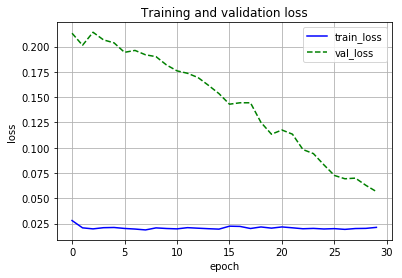

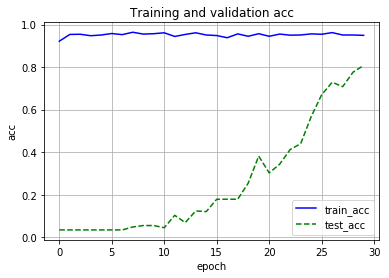

In [28]:
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='test_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation acc')
plt.grid()

# Test cosine similarity

In [102]:
def get_score(model, num_classes, train_dataloader, test_dataloader):
    hold_vector = np.empty(num_classes)
    predict_vector = None
    Y = []
    for i, (x,y) in enumerate(train_loader):
        with torch.no_grad():
            x = x.to(device)
            y = y.data.cpu().numpy()
            print(y)
            features = model(x)
            features = features.data.cpu().numpy()
            hold_vector = np.append(hold_vector, features, axis=y)

    for i, (x,y) in enumerate(test_loader):
        with torch.no_grad():
            x = x.to(device)
            y = y.to(device)
            features = model(x)
            features = features.data.cpu().numpy()
        if predict_vector is None:
            predict_vector = features
        else:
            predict_vector = np.vstack((predict_vector, features))
        Y += [int(l) for l in y]
        
    score =[]
    for i in range(len(predict_vector)):
        cos_similarity = cosine_similarity(predict_vector[i], hold_vector)
        score.append(np.max(cos_similarity))
    
    return np.array(score), Y

def cosine_similarity(x1, x2):
    if x1.ndim == 1:
        x1 = x1[np.newaxis]
    if x2.ndim == 1:
        x2 = x2[np.newaxis]
    x1_norm = np.linalg.norm(x1, axis=1)
    x2_norm = np.linalg.norm(x2, axis=1)
    cosine_sim = np.dot(x1, x2.T)/(x1_norm*x2_norm+1e-10)
    return cosine_sim

net = net.eval()

pred = []
Y = []
for i, (x,y) in enumerate(test_loader):
    with torch.no_grad():
        x = x.to(device)
        y = y.to(device)
        features = net(x)
        output = metric_fc(features,y)
    pred += [int(l.argmax()) for l in output]
    Y += [int(l) for l in y]

In [103]:
score, Y = get_score(net, num_classes, train_loader, test_loader)
pred = []
print(score)
for i in range(len(score)):
    pred.append(np.argmax(score[i]))

[2 5 0 5 2 5 5 2 2 6 5 5 2 5 5 2]


TypeError: only integer scalar arrays can be converted to a scalar index

In [66]:
print(len(score))

364


In [55]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

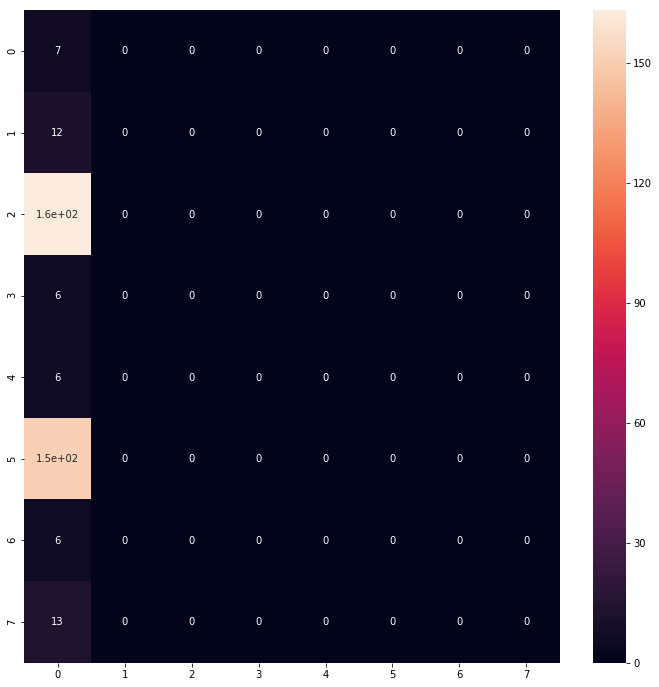

accuracy: 0.019230769230769232


In [56]:
cmx = confusion_matrix(Y, pred)
plt.figure(figsize=(12,12))
sns.heatmap(cmx, annot=True)
plt.show()
print('accuracy: {}'.format(accuracy_score(Y, pred)))

In [57]:
print(classification_report(Y, pred))

              precision    recall  f1-score   support

           0       0.02      1.00      0.04         7
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00       163
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00       151
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00        13

   micro avg       0.02      0.02      0.02       364
   macro avg       0.00      0.12      0.00       364
weighted avg       0.00      0.02      0.00       364



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
print(cor_table)

              s_class
labels               
0        [lab_bs_cnt]
1        [lab_corner]
2          [lab_desk]
3           [lab_ent]
4       [lab_printer]
5         [lab_table]
6        [lab_wb_cnt]
7        [lab_wb_ent]


# Scatter plotting

In [59]:
from mpl_toolkits.mplot3d import Axes3D

Text(0.5, 0.92, 'ArcFace')

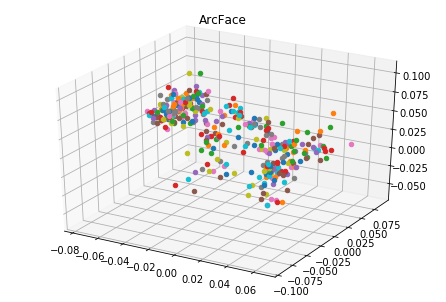

In [60]:
preds = None
Y = []
for i, (x,y) in enumerate(test_loader):
    with torch.no_grad():
        x = x.to(device)
        y = y.to(device)
        features = net(x)
        features = features.data.cpu().numpy()
        if preds is None:
            preds = features
        else:
            preds = np.vstack((preds, features))
    Y += [int(l) for l in y]
preds /= np.linalg.norm(preds, axis=1, keepdims=True)
fig = plt.figure()
ax = Axes3D(fig)
for c in range(len(np.unique(Y))):
    for i in range(len(Y)):
        if Y[i] == c:
            ax.scatter(preds[i][0], preds[i][1], preds[i][2])
plt.title('ArcFace')

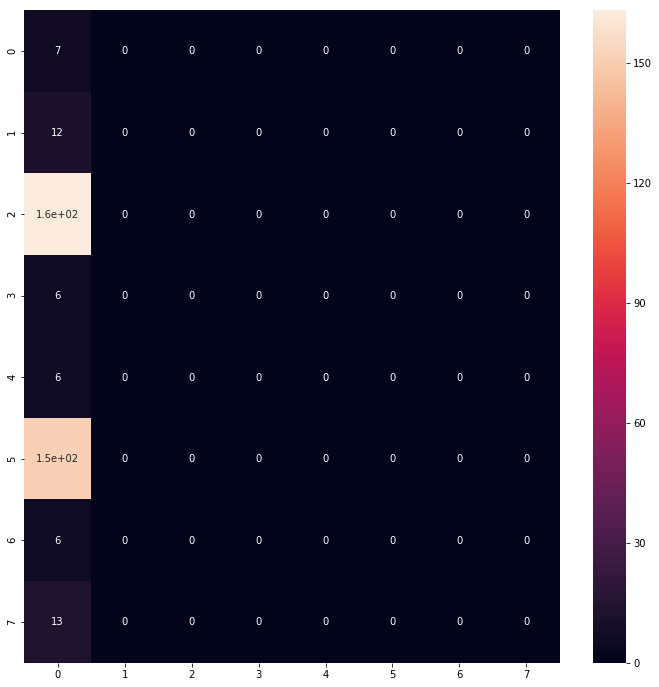

accuracy: 0.019230769230769232


In [61]:
cmx = confusion_matrix(Y, pred)
plt.figure(figsize=(12,12))
sns.heatmap(cmx, annot=True)
plt.show()
print('accuracy: {}'.format(accuracy_score(Y, pred)))

In [62]:
print(classification_report(Y, pred))

              precision    recall  f1-score   support

           0       0.02      1.00      0.04         7
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00       163
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00       151
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00        13

   micro avg       0.02      0.02      0.02       364
   macro avg       0.00      0.12      0.00       364
weighted avg       0.00      0.02      0.00       364



In [63]:
print(cor_table)

              s_class
labels               
0        [lab_bs_cnt]
1        [lab_corner]
2          [lab_desk]
3           [lab_ent]
4       [lab_printer]
5         [lab_table]
6        [lab_wb_cnt]
7        [lab_wb_ent]


# Heatmap

In [ ]:
from bagnets.utils import plot_heatmap, generate_heatmap_pytorch

In [ ]:
pred = []
Y = []
for i, (x,y) in enumerate(heatmap_loader):
    with torch.no_grad():
        x = x.to(device)
        y = y.to(device)
        features = net(x)
        output = metric_fc(features,y)
    pred += [int(l.argmax()) for l in output]
    Y += [int(y)]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

In [ ]:
cmx = confusion_matrix(Y, pred, labels=cor_table.index)
plt.figure(figsize=(12,12))
sns.heatmap(pd.DataFrame(cmx, columns=cor_table.index, index=cor_table.index), annot=True)
plt.show()
print('accuracy: {}'.format(accuracy_score(Y, pred)))

In [ ]:
pd.set_option("display.max_columns",50)
pd.DataFrame({'Y':Y, 'pred':pred}).T

In [ ]:
print(classification_report(Y, pred))

In [ ]:
cor_table

In [ ]:
net.eval()

In [ ]:
def show_heatmap(net, heatmap_dataframe):
    nps = np.array(heatmap_dataframe)
    for row in nps:
        with open(row[0], 'rb') as f:
            image = Image.open(f)
            image = image.convert('RGB')
            image = image.resize((224,224))
            image = transforms.Compose([
                transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])(image)
            image = torch.unsqueeze(image,0)
            original, label = image, [row[1]]
            # torch.Tensor->np.arrayに変換
            # generate_heatmap_pytorchにはnp.arrayの入力が必要
            original = original.numpy()

        heatmap = generate_heatmap_pytorch(net, original, label, 33)

        fig = plt.figure(figsize=(8,4))
        original_image = original[0].transpose([1,2,0])
        ax = plt.subplot(121)
        ax.set_title('original')
        plt.imshow(original_image)
        plt.axis('off')

        ax = plt.subplot(122)
        ax.set_title('heatmap')
        plot_heatmap(heatmap, original_image, ax, dilation=0.5, percentile=99, alpha=.25)

        plt.axis('off')
        plt.show()

In [ ]:
show_heatmap(net, heatmap_df)

In [ ]:
heatmap_df

In [ ]:
torch.save(net.state_dict(),'/home/tamaru/scene_categorize/main/data/bagnet-pytorch.pth')

# 重みのロード方法
net = TheModelClass(*args, **kwargs)
net.load_state_dict(torch.load(PATH))